In [1]:
import os
import pdb
import h5py
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

# Config

In [2]:
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
enformer_data_dir = "/global/scratch/users/aniketh/enformer_data/"
models_dir = "/global/scratch/users/aniketh/finetune-enformer/saved_models/"
test_preds_dir = "/global/scratch/users/aniketh/finetune-enformer/test_preds_final/"

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")

GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
BASELINE_PREDS_PATH = (
    "../process_geuvadis_data/enformer_sample_preds.csv"
)
test_h5 = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/test.h5"

all_main_run_names={
    "classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_parallel_h5_dataset_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "single_regression_counts": "NCCL_P2P_DISABLE=1 python finetuning/train_single_counts_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
#     "single_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_single_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint", ###DOEST PERFORM WELL, NOT USED
    "joint_classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
}
all_seeds = [42, 97, 7]
subsample_fracs = [0.2, 0.4, 0.6, 0.8]

In [3]:
ALL_PREDS_PATHS = {}

# MAIN TEST RUNS
for run in all_main_run_names:
    for i, seed in enumerate(all_seeds):
        train_cmd_template = all_main_run_names[run]
        lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[0]
        wd_used_during_training = train_cmd_template.split("--weight_decay ")[-1].split(" ")[0]
        rcprob_used_during_training = 0.5
        rsmax_used_during_training = 3
            
        model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
        ALL_PREDS_PATHS[model_name] = os.path.join(test_preds_dir, model_name)
        
# TEST RUNS FOR SUBSAMPLED TRAIN SET RUNS FOR REGRESSION
for run in ["regression"]:
    for i, seed in enumerate(all_seeds):
        for j, frac in enumerate(subsample_fracs):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[0]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[-1].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3
            
            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}_subsample_ratio_{frac}"
            ALL_PREDS_PATHS[model_name] = os.path.join(test_preds_dir, model_name)
        
test_h5 = h5py.File(test_h5_path, "r")

# Read test set predictions and compute correlations

In [4]:
def load_geuvadis_data() -> pd.DataFrame:
    counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col=0)
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    return counts_df

In [5]:
def load_finetuned_preds(PREDS_PATH):
    """
    Returns a dictionary of dictionaries, where the outer keys are the genes
    and the inner keys are the samples. The values are the predictions.
    """
    preds_by_gene = defaultdict(dict)
    ancestries_by_gene = defaultdict(dict)
    data = np.load(os.path.join(PREDS_PATH, "test_preds.npz"))

    preds, genes, samples = data["preds"], data["genes"], data["samples"]
    ancestries = test_h5["ancestries"][:].astype(str)
    for (pred, gene, sample, ancestry) in zip(preds, genes, samples, ancestries):
        preds_by_gene[gene][sample] = pred
        ancestries_by_gene[gene][sample] = ancestry
    return preds_by_gene, ancestries_by_gene


def get_finetuned_corrs(finetuned_preds, geuvadis_df):
    corrs = {}
    for g in finetuned_preds:
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())
        gene_preds = [finetuned_preds[g][s] for s in samples]
        gene_counts = geuvadis_df.loc[g, samples].values.astype("float32")
        assert np.isnan(gene_preds).sum() == 0
        assert np.isnan(gene_counts).sum() == 0
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]
        
        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(f"Gene {g} has invalid predictions/counts and thus has a nan pearsonR")
            corrs[g] = 0
            
    return corrs


def compare_to_geuvadis_counts(finetuned_preds, geuvadis_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    gene_preds = [finetuned_preds[gene][s] for s in samples]
    gene_counts = geuvadis_df.loc[gene, samples].values
    ax.scatter(gene_counts, gene_preds)
    ax.set(
        xlabel="Geuvadis counts",
        ylabel="finetuned predictions",
        title=f"Correlation: {pearsonr(gene_preds, gene_counts)[0]:.3f}",
    )


def compare_to_baseline_counts(finetuned_preds, baseline_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    baseline_preds = baseline_df[gene][samples].values
    finetuned_preds = [finetuned_preds[gene][s] for s in samples]
    ax.scatter(baseline_preds, finetuned_preds)
    ax.set(
        xlabel="baseline predictions",
        ylabel="finetuned predictions",
        title=f"Correlation: {pearsonr(baseline_preds, finetuned_preds)[0]:.3f}",
    )

In [6]:
def load_other_model_preds_df(preds_df_path):
    preds_df = pd.read_csv(preds_df_path, index_col=0)
    return preds_df


def get_other_model_corrs(preds_df, geuvadis_df, finetuned_preds):
    corrs = {}
    for g in finetuned_preds:
        assert g in preds_df.columns
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())

        gene_preds = preds_df[g][samples].values
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]
        
        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(f"Gene {g} has invalid predictions/counts and thus has a nan PearsonR")
            corrs[g] = 0
            
    return corrs

In [7]:
def compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, ancestries_by_gene, abs_corrs: bool = False
):
    genes = list(finetuned_corrs.keys())
    finetuned_corrs_l = [finetuned_corrs[g] for g in genes]
    baseline_corrs_l = [baseline_corrs[g] for g in genes]
    
    gene_class = []
    for g in genes:
        temp = np.array([ancestries_by_gene[g][key] for key in ancestries_by_gene[g]])
        if (temp != "Yoruba").sum() == 0:
            gene_class.append("yri_split")
        elif len(finetuned_preds[g]) <= 77:
            gene_class.append("random_split")
        else:
            gene_class.append("unseen")
    
    df = pd.DataFrame(
        {
            "gene": genes,
            "finetuned Spearman": np.abs(finetuned_corrs_l) 
            if abs_corrs 
            else finetuned_corrs_l,
            "baseline Spearman": np.abs(baseline_corrs_l)
            if abs_corrs
            else baseline_corrs_l,
            "gene_class": gene_class,
        }
    )

    ax = sns.scatterplot(
        data=df,
        x="baseline Spearman",
        y="finetuned Spearman",
        hue="gene_class",
    )
    ax.set_ylabel("|finetuned Spearman|" if abs_corrs else "finetuned Spearman")
    ax.set_xlabel("|baseline Spearman|" if abs_corrs else "baseline Spearman")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set(aspect="equal", xlim=lims, ylim=lims)
    
    ax.axhline(
        df[df["gene_class"] == "random_split"]["finetuned Spearman"].mean(),
        color="blue",
        ls="--",
        label="random_split"
    )
    ax.axvline(
        df[df["gene_class"] == "random_split"]["baseline Spearman"].mean(),
        color="blue",
        ls="--",
        label="random_split"
    )

    ax.axhline(
        df[df["gene_class"] == "yri_split"]["finetuned Spearman"].mean(),
        color="orange",
        ls="--",
        label="yri_split"
    )
    ax.axvline(
        df[df["gene_class"] == "yri_split"]["baseline Spearman"].mean(),
        color="orange",
        ls="--",
        label="yri_split"
    )
    
    ax.axhline(
        df[df["gene_class"] == "unseen"]["finetuned Spearman"].mean(),
        color="green",
        ls="--",
        label="unseen"
    )
    ax.axvline(
        df[df["gene_class"] == "unseen"]["baseline Spearman"].mean(),
        color="green",
        ls="--",
        label="unseen"
    )
    
    summary = {}
    
    for split in ["random_split", "yri_split", "unseen"]:
        print(f"Split {split}, n_samples = {(df['gene_class'] == split).sum()}")
        print(f"Baseline PearsonR = {df[df['gene_class'] == split]['baseline Spearman'].mean()}")
        print(f"Finetuned PearsonR = {df[df['gene_class'] == split]['finetuned Spearman'].mean()}")
        print()
        
        summary["Baseline " + split] = df[df['gene_class'] == split]['baseline Spearman'].mean()
        summary["Finetuned " + split] = df[df['gene_class'] == split]['finetuned Spearman'].mean()

    plt.show()
    return summary

In [8]:
geuvadis_df = load_geuvadis_data()
baseline_df = load_other_model_preds_df(BASELINE_PREDS_PATH)

classification_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2844971575752882

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16718678125924807

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.05840994003236499



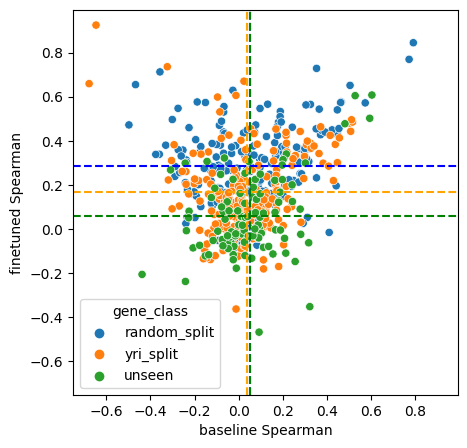

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2903297049040467

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19529911932379362

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.1370004755564583



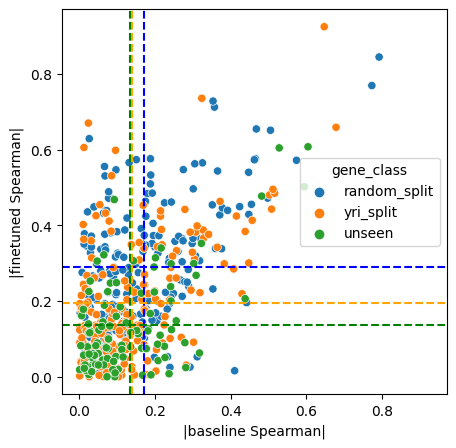

classification_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2872947362573528

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.17066781529837294

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.02005952504310517



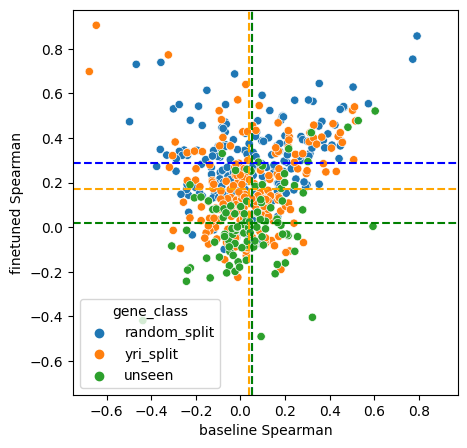

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.29247307187302474

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19542859050529407

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13376489619305712



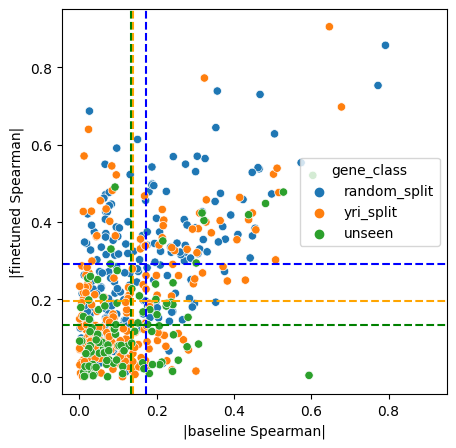

classification_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.28023437285420144

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.15450001463786564

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.05149472131627092



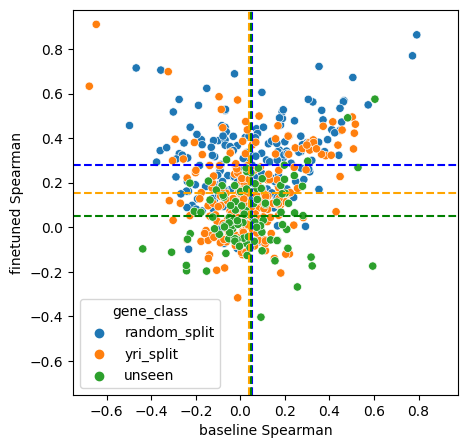

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.28748450489794525

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18844012603256588

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.12165702910894347



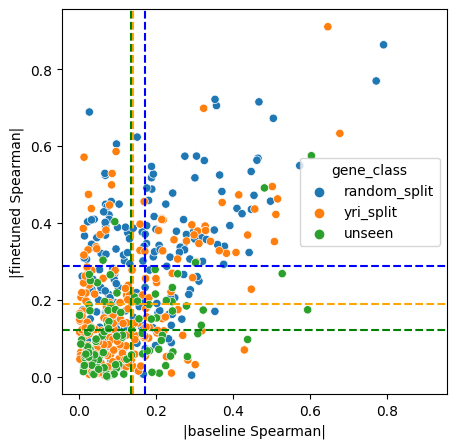

regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2777387260096611

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16751589011498683

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.048736100838161295



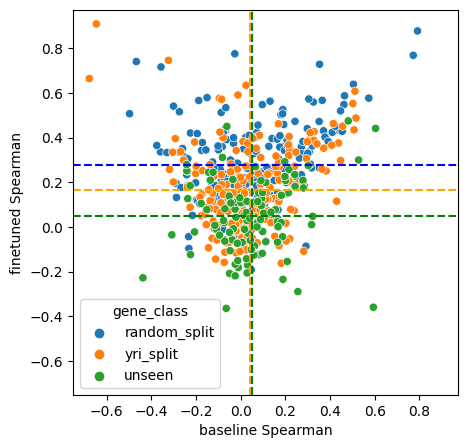

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2864498208251164

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19199188102290024

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13755470070099546



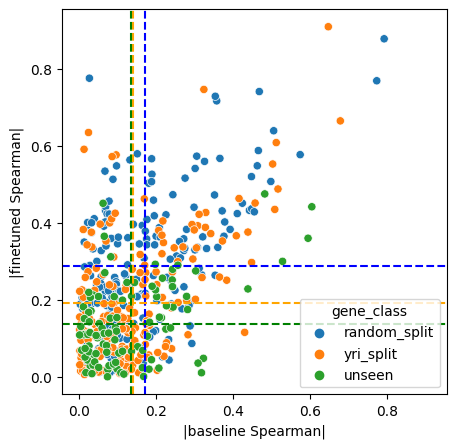

regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.28652725175724975

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.1694765095981889

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.04431906920515272



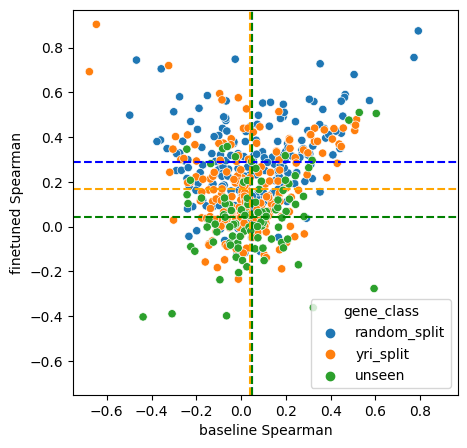

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2924177726007687

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.1950672131816264

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.1356630337502767



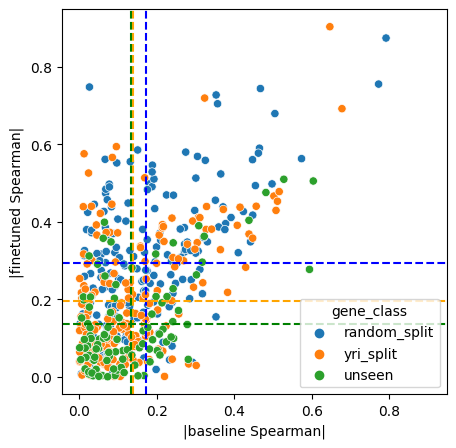

regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2802915051501422

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.17270695717684426

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.060495804249331424



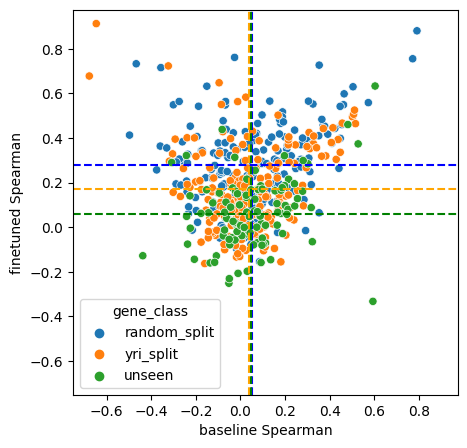

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.285579802038548

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.1931652604974186

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.12745238395613798



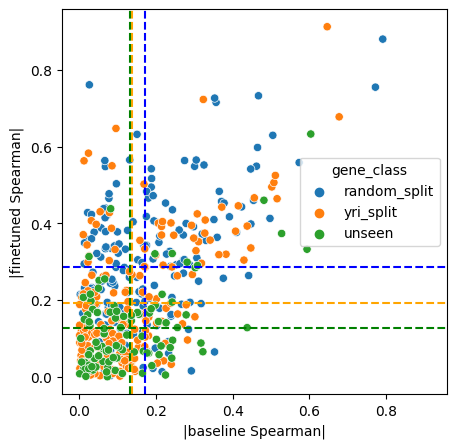

single_regression_counts_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.22933072071669883

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.12794970209008072

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.021491541229631067



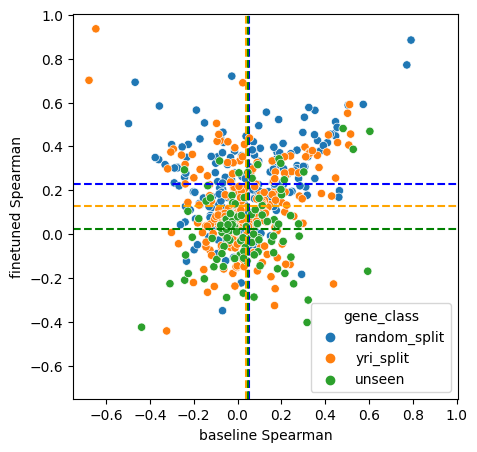

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.24835076446176652

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18386428010469338

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13368484073253964



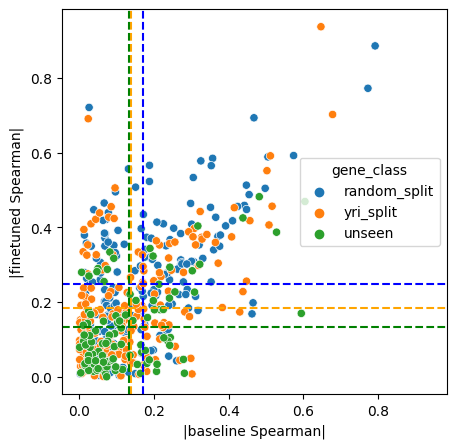

single_regression_counts_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.22490085857920206

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.13072568623478695

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.04760627573517777



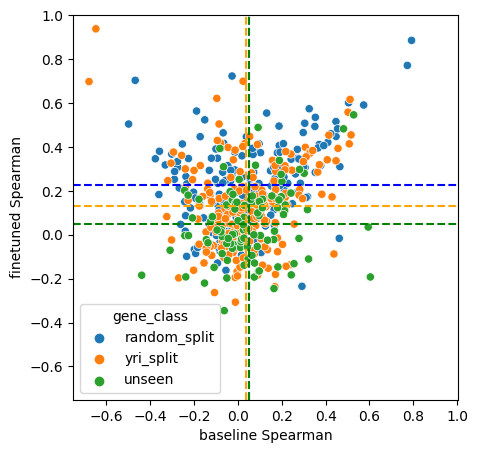

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.24085183952837375

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.17957906194550285

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.1314842215368026



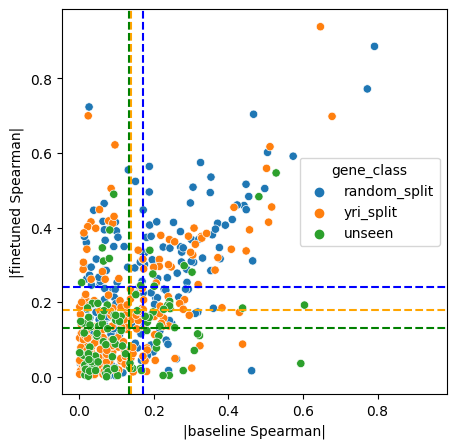

single_regression_counts_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2180967852373051

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.12219919200270336

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.04507468832200029



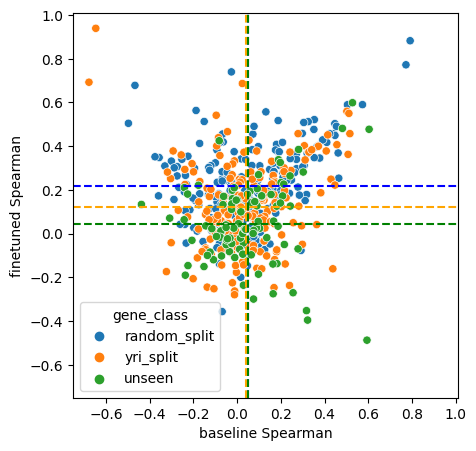

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2361964083454267

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.17755888411308557

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.14292938456887258



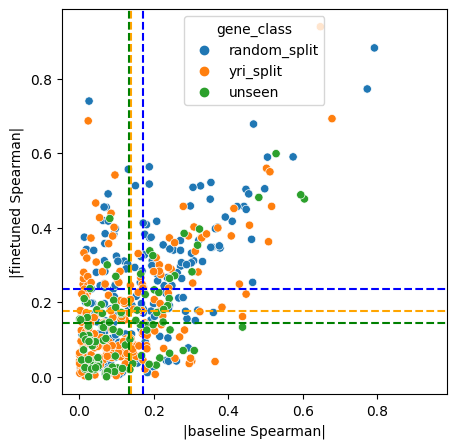

joint_classification_data_seed_42_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.28208634671125643

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.1694928907747048

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.04901280110765865



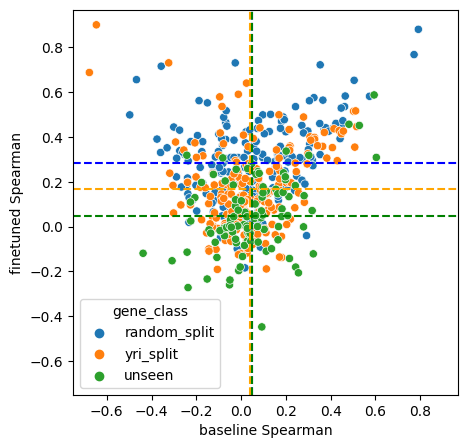

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2890439247250415

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19333012512825348

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13239244277090956



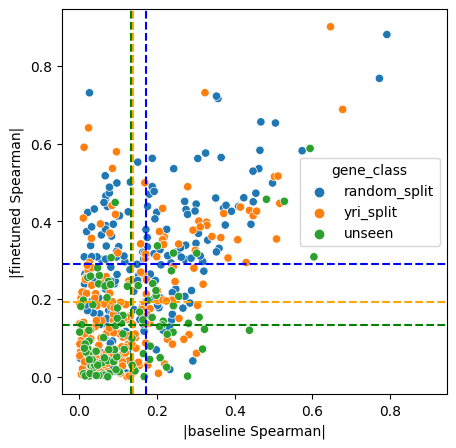

joint_classification_data_seed_97_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.28058401167815916

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16832206241351108

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.045706811036111496



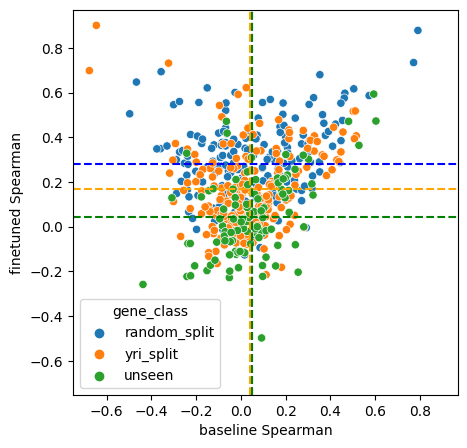

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.28509624603962996

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.1889761528226399

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.14942693866752985



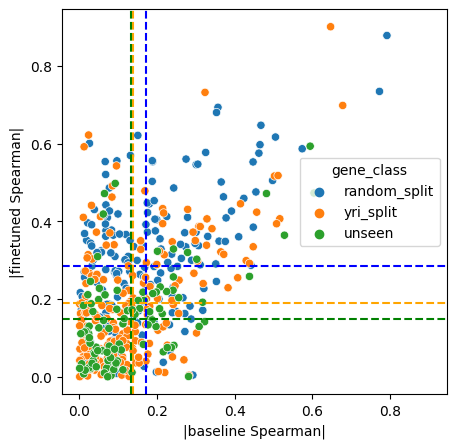

joint_classification_data_seed_7_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.27948303868225305

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16668401129800445

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.05688172506557377



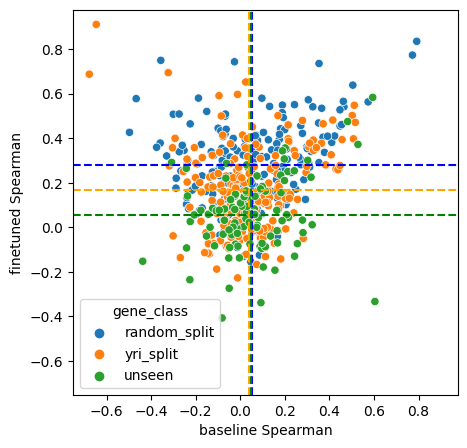

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2868321491253718

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19544027690772722

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13283431222253023



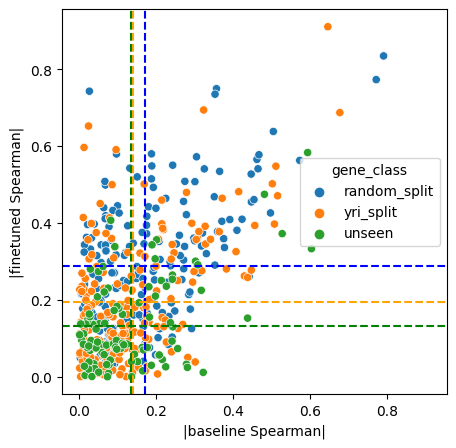

joint_regression_data_seed_42_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.236629134173601

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.13929641555118194

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.01945252708587493



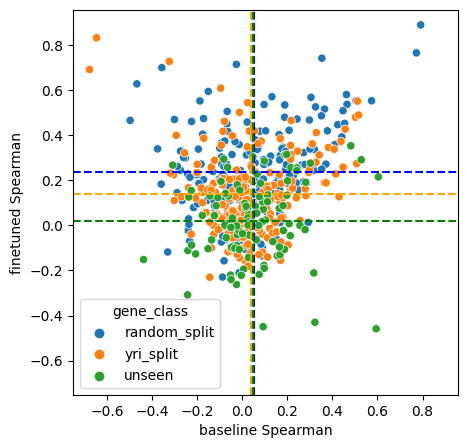

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.256371086719396

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.17142417349148992

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.1346716649773927



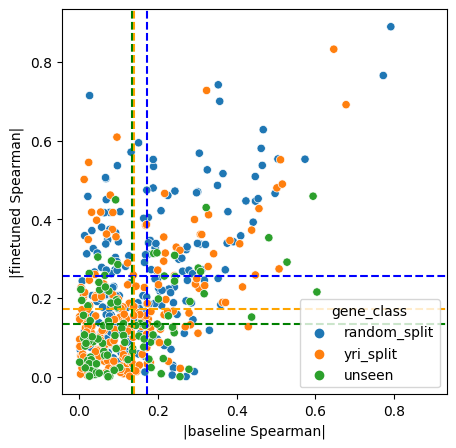

joint_regression_data_seed_97_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.23829817839820022

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.1378434622412094

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.015425256306327715



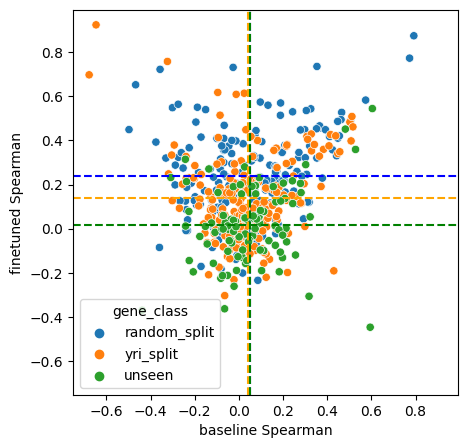

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.25424424037637144

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.17711378842652883

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.12557786016741887



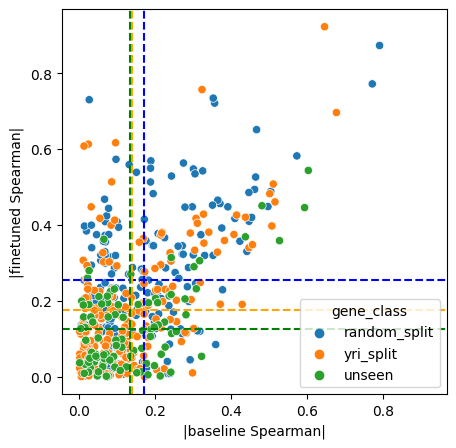

joint_regression_data_seed_7_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.23360937035191573

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.1460711015691729

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.00766516143585881



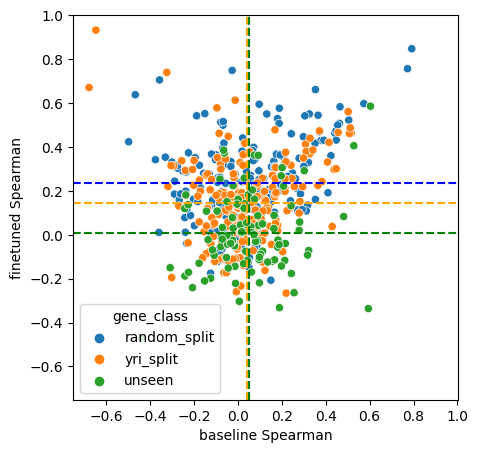

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.24992969991953765

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18555054111055305

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13520520793917273



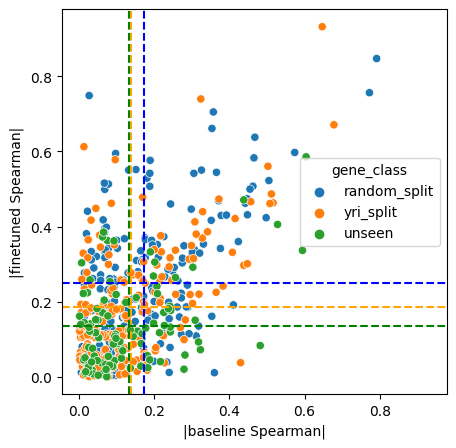

regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2194924947674339

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.12957589243313555

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.06275685583542571



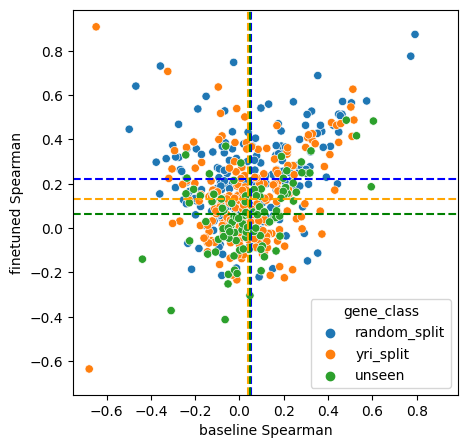

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.24074278131754936

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.17605850373463924

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.1380328284573469



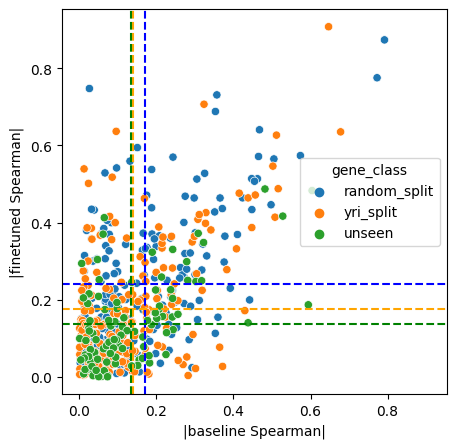

regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2439364459904011

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16142662252563106

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.04164827871455271



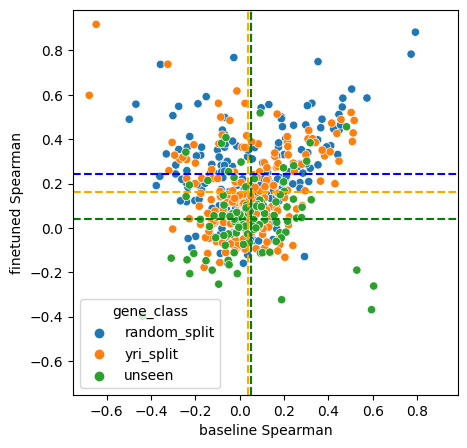

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.25828740489765495

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18489416826622332

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.12709388423693077



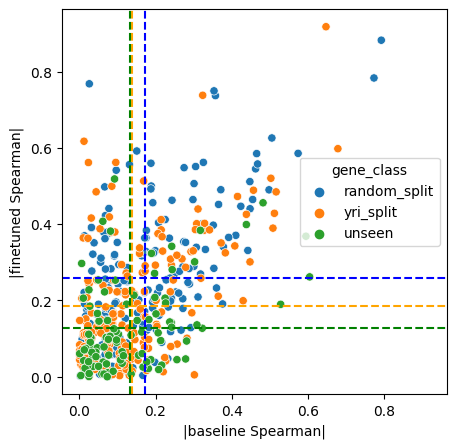

regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.6


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2560885630610594

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16128476439616954

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.07343843901393567



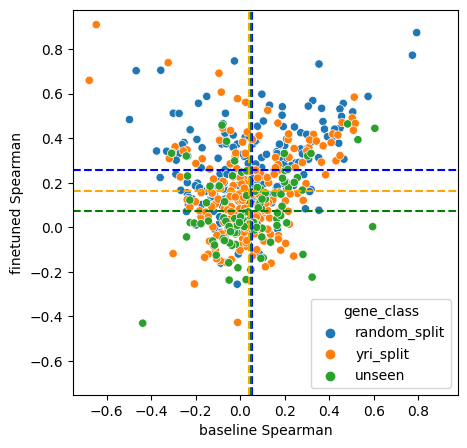

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2670353335434425

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19845260426142317

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13148672413700074



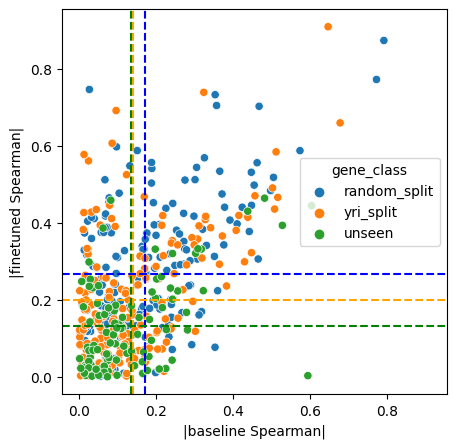

regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.8


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2677024514369638

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16334298853385334

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.06253373314044226



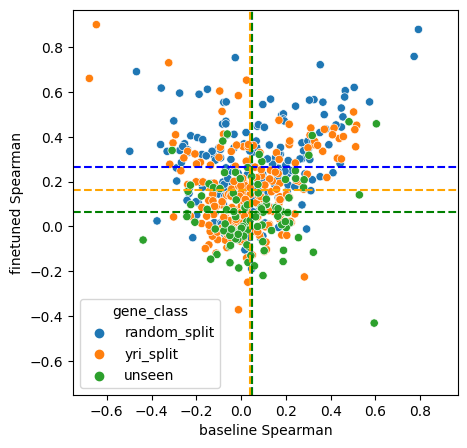

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2739763209809996

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18858962074701002

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.12513090762521803



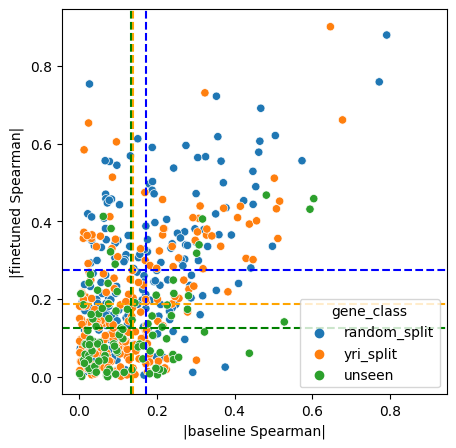

regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2191118958713985

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.12573577423046622

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.06095453488493884



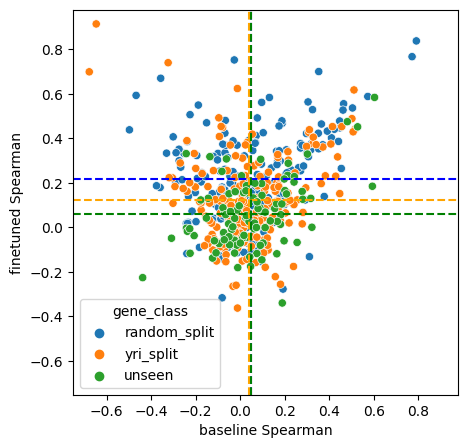

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.24368341902736637

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.17169469947039723

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.12300430870947687



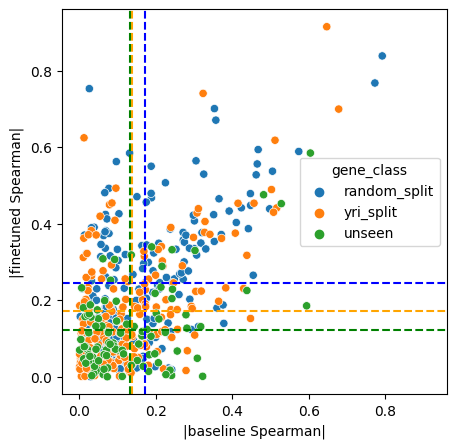

regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.24849989524622948

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16269715671950225

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.0568013174354732



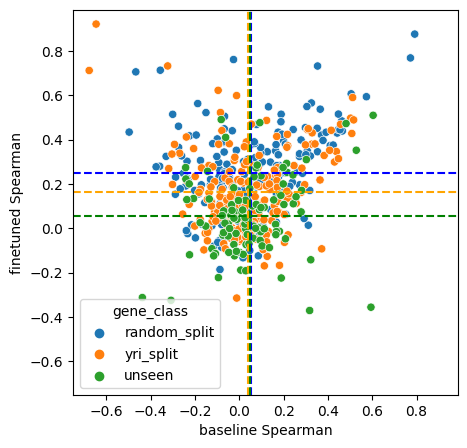

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2610232917483939

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18453206356951327

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13873661595807532



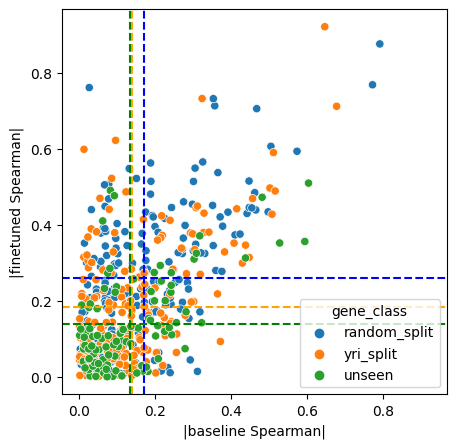

regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.6


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2669357782796733

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.154175422347838

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.05319334704580503



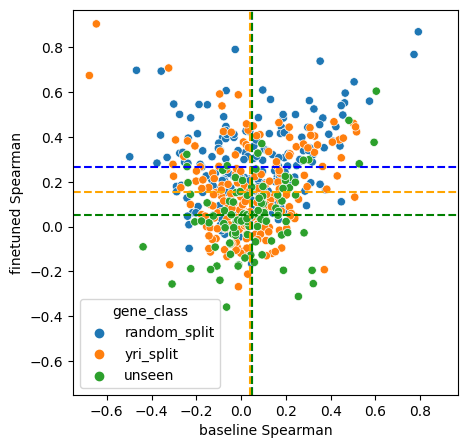

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.27187810757071246

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18495505286063718

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.1353116306936006



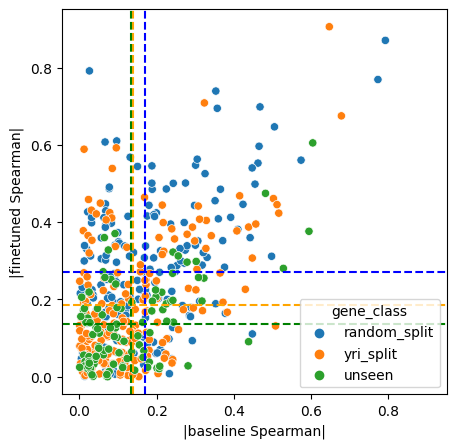

regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.8


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.27761980503370043

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16475749543772678

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.06708715826729204



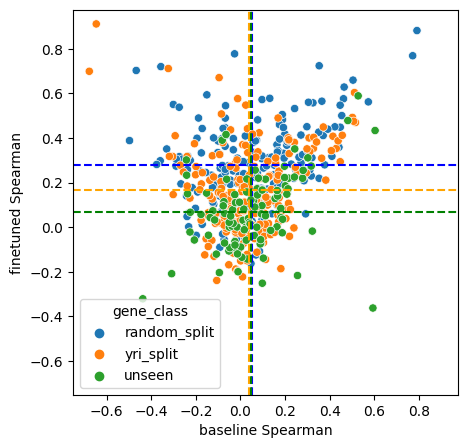

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2855732321583484

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19628901863747383

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13711297132288447



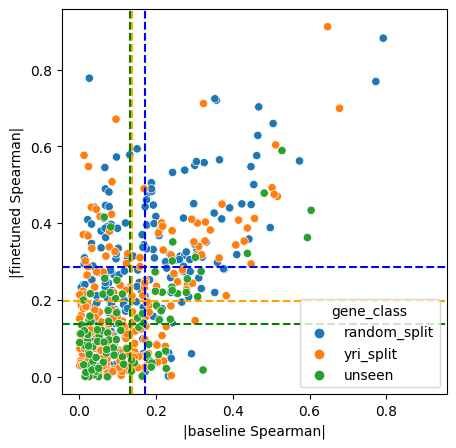

regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.21715206279071034

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.13519956128534052

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.055887270186104336



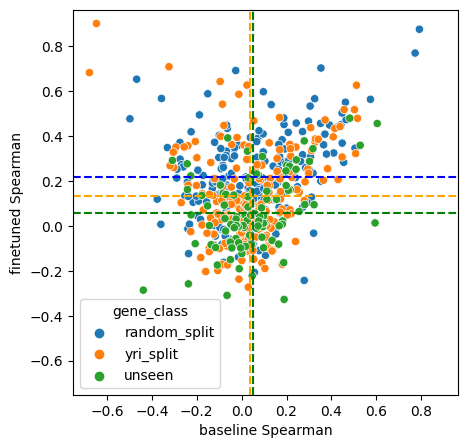

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2359602746004545

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.1822667221054209

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.1305674332515242



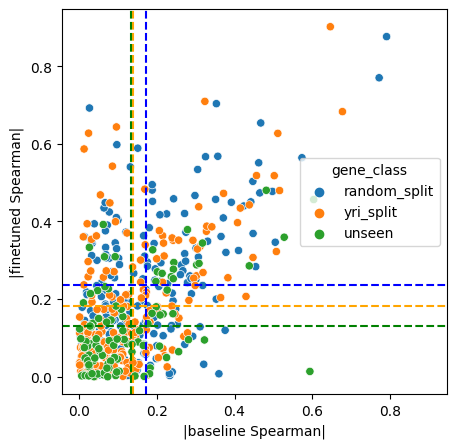

regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.2589452688463845

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.1476402613679841

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.040211138901190234



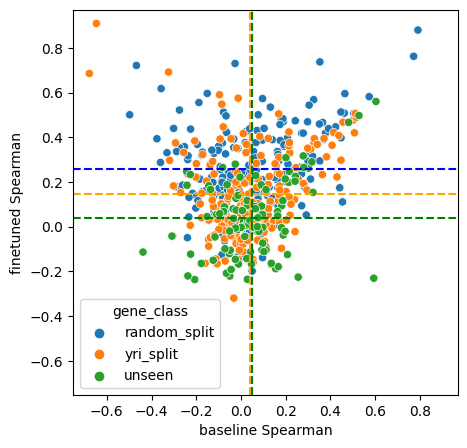

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.2719750996262057

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18076941122282722

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13473743343298003



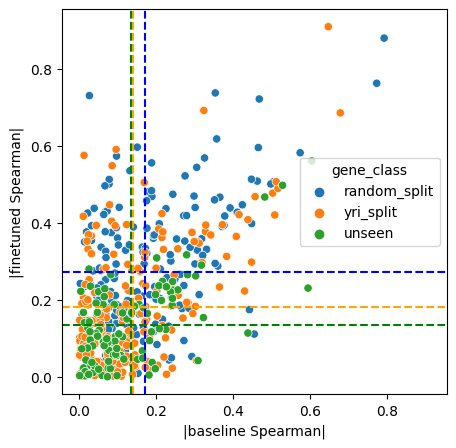

regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.6


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.27463599240641384

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.15760573303223002

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.06098794776227483



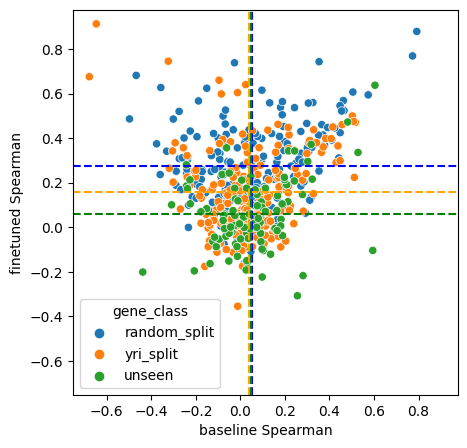

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.28031159561588426

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.18487729558657445

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.12768276187085104



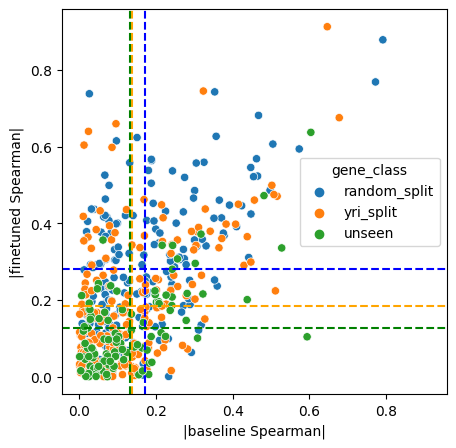

regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.8


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
Split random_split, n_samples = 200
Baseline PearsonR = 0.05043372951320018
Finetuned PearsonR = 0.27846306484283906

Split yri_split, n_samples = 200
Baseline PearsonR = 0.0394170639885106
Finetuned PearsonR = 0.16318565027908896

Split unseen, n_samples = 100
Baseline PearsonR = 0.04953789939749413
Finetuned PearsonR = 0.0608334235745413



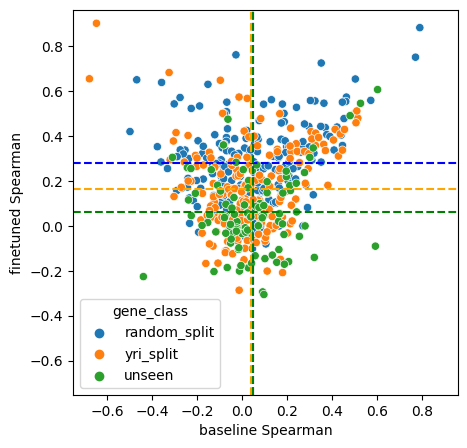

Split random_split, n_samples = 200
Baseline PearsonR = 0.17131491153658124
Finetuned PearsonR = 0.28278635865971685

Split yri_split, n_samples = 200
Baseline PearsonR = 0.13860592568504226
Finetuned PearsonR = 0.19083110511319007

Split unseen, n_samples = 100
Baseline PearsonR = 0.13331019486555476
Finetuned PearsonR = 0.13844939347894736



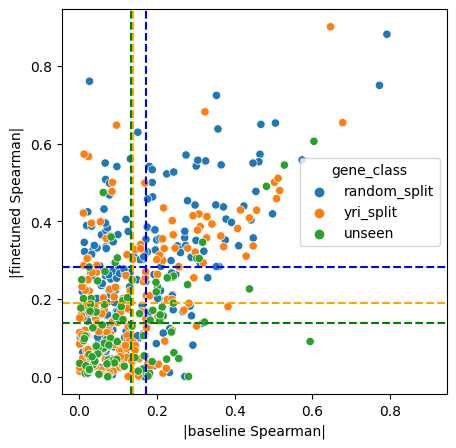

In [9]:
summary_df = {}
summary_df["Model"] = []
summary_df["random_split Genes Avg PearsonR"] = []
summary_df["yri_split Genes Avg PearsonR"] = []
summary_df["unseen Genes Avg PearsonR"] = []
summary_df["random_split Genes Avg |PearsonR|"] = []
summary_df["yri_split Genes Avg |PearsonR|"] = []
summary_df["unseen Genes Avg |PearsonR|"] = []

for model in ALL_PREDS_PATHS:
    print(model)
    
    if len(summary_df["Model"]) == 0:
        summary_df["Model"].append("Baseline Enformer")
    
    summary_df["Model"].append(model)
    
    PREDS_PATH = ALL_PREDS_PATHS[model]
    finetuned_preds, ancestries_by_gene = load_finetuned_preds(PREDS_PATH)
    finetuned_corrs = get_finetuned_corrs(finetuned_preds, geuvadis_df)
    baseline_corrs = get_other_model_corrs(baseline_df, geuvadis_df, finetuned_preds)
    
    fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
    s = compare_finetuned_to_baseline_perf(
        finetuned_corrs, baseline_corrs, finetuned_preds, ancestries_by_gene
    )
    
    for split in ["random_split", "yri_split", "unseen"]:
        if len(summary_df[f"{split} Genes Avg PearsonR"]) == 0:
            summary_df[f"{split} Genes Avg PearsonR"].append(s["Baseline " + split])
        
        summary_df[f"{split} Genes Avg PearsonR"].append(s["Finetuned " + split])
    
    fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
    s = compare_finetuned_to_baseline_perf(
        finetuned_corrs, baseline_corrs, finetuned_preds, ancestries_by_gene, abs_corrs=True
    )
    
    for split in ["random_split", "yri_split", "unseen"]:
        if len(summary_df[f"{split} Genes Avg |PearsonR|"]) == 0:
            summary_df[f"{split} Genes Avg |PearsonR|"].append(s["Baseline " + split])
        
        summary_df[f"{split} Genes Avg |PearsonR|"].append(s["Finetuned " + split])
        
summary_df = pd.DataFrame(summary_df)

In [10]:
summary_df

Model  \
0                                   Baseline Enformer   
1   classification_data_seed_42_lr_0.0001_wd_0.001...   
2   classification_data_seed_97_lr_0.0001_wd_0.001...   
3   classification_data_seed_7_lr_0.0001_wd_0.001_...   
4   regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
5   regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
6   regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
7   single_regression_counts_data_seed_42_lr_0.000...   
8   single_regression_counts_data_seed_97_lr_0.000...   
9   single_regression_counts_data_seed_7_lr_0.0001...   
10  joint_classification_data_seed_42_lr_0.0005_wd...   
11  joint_classification_data_seed_97_lr_0.0005_wd...   
12  joint_classification_data_seed_7_lr_0.0005_wd_...   
13  joint_regression_data_seed_42_lr_0.0005_wd_0.0...   
14  joint_regression_data_seed_97_lr_0.0005_wd_0.0...   
15  joint_regression_data_seed_7_lr_0.0005_wd_0.00...   
16  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
17  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
18  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
19  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
20  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
21  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
22  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
23  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
24  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
25  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
26  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
27  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   

    random_split Genes Avg PearsonR  yri_split Genes Avg PearsonR  \
0                          0.050434                      0.039417   
1                          0.284497                      0.167187   
2                          0.287295                      0.170668   
3                          0.280234                      0.154500   
4                          0.277739                      0.167516   
5                          0.286527                      0.169477   
6                          0.280292                      0.172707   
7                          0.229331                      0.127950   
8                          0.224901                      0.130726   
9                          0.218097                      0.122199   
10                         0.282086                      0.169493   
11                         0.280584                      0.168322   
12                         0.279483                      0.166684   
13                         0.236629                      0.139296   
14                         0.238298                      0.137843   
15                         0.233609                      0.146071   
16                         0.219492                      0.129576   
17                         0.243936                      0.161427   
18                         0.256089                      0.161285   
19                         0.267702                      0.163343   
20                         0.219112                      0.125736   
21                         0.248500                      0.162697   
22                         0.266936                      0.154175   
23                         0.277620                      0.164757   
24                         0.217152                      0.135200   
25                         0.258945                      0.147640   
26                         0.274636                      0.157606   
27                         0.278463                      0.163186   

    unseen Genes Avg PearsonR  random_split Genes Avg |PearsonR|  \
0                    0.049538                           0.171315   
1                    0.058410                           0.290330   
2                    0.020060                           0.292473   
3                    0.051495                           0.287485   
4                    0.048736                       

# Generate figure comparing all methods

In [11]:
model_type = []
replicate = []
subsample_ratio = []

for i in range(summary_df.shape[0]):
    row = summary_df.iloc[i]
    if row["Model"].startswith("classification_"):
        model_type.append("Pairwise \nClassification")
        replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
        subsample_ratio.append(-1)
        
    elif row["Model"].startswith("regression_"):
        replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
        if "subsample" in row["Model"]:
            subsample_ratio.append(float(row["Model"].split("subsample_ratio_")[-1]))
            model_type.append("Pairwise \nRegression \nwith {}% of Samples".format(int(subsample_ratio[-1] * 100)))
        else:
            subsample_ratio.append(1.0)
            model_type.append("Pairwise \nRegression")
            
    elif row["Model"].startswith("single_regression_"):
        model_type.append("Single Sample \nRegression")
        replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
        subsample_ratio.append(-1)
        
    elif row["Model"].startswith("joint_classification_"):
        model_type.append("Pairwise \nClassification \nwith Joint Training")
        replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
        subsample_ratio.append(-1)
        
    elif row["Model"].startswith("joint_regression_"):
        model_type.append("Pairwise \nRegression \nwith Joint Training")
        replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
        subsample_ratio.append(-1)
        
    else:
        model_type.append(row["Model"])
        replicate.append(0)
        subsample_ratio.append(-1)
        
summary_df["Model Type"] = model_type
summary_df["Replicate"] = replicate
summary_df["Subsample Ratio"] = subsample_ratio

In [12]:
summary_df

Model  \
0                                   Baseline Enformer   
1   classification_data_seed_42_lr_0.0001_wd_0.001...   
2   classification_data_seed_97_lr_0.0001_wd_0.001...   
3   classification_data_seed_7_lr_0.0001_wd_0.001_...   
4   regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
5   regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
6   regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
7   single_regression_counts_data_seed_42_lr_0.000...   
8   single_regression_counts_data_seed_97_lr_0.000...   
9   single_regression_counts_data_seed_7_lr_0.0001...   
10  joint_classification_data_seed_42_lr_0.0005_wd...   
11  joint_classification_data_seed_97_lr_0.0005_wd...   
12  joint_classification_data_seed_7_lr_0.0005_wd_...   
13  joint_regression_data_seed_42_lr_0.0005_wd_0.0...   
14  joint_regression_data_seed_97_lr_0.0005_wd_0.0...   
15  joint_regression_data_seed_7_lr_0.0005_wd_0.00...   
16  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
17  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
18  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
19  regression_data_seed_42_lr_0.0001_wd_0.001_rcp...   
20  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
21  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
22  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
23  regression_data_seed_97_lr_0.0001_wd_0.001_rcp...   
24  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
25  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
26  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   
27  regression_data_seed_7_lr_0.0001_wd_0.001_rcpr...   

    random_split Genes Avg PearsonR  yri_split Genes Avg PearsonR  \
0                          0.050434                      0.039417   
1                          0.284497                      0.167187   
2                          0.287295                      0.170668   
3                          0.280234                      0.154500   
4                          0.277739                      0.167516   
5                          0.286527                      0.169477   
6                          0.280292                      0.172707   
7                          0.229331                      0.127950   
8                          0.224901                      0.130726   
9                          0.218097                      0.122199   
10                         0.282086                      0.169493   
11                         0.280584                      0.168322   
12                         0.279483                      0.166684   
13                         0.236629                      0.139296   
14                         0.238298                      0.137843   
15                         0.233609                      0.146071   
16                         0.219492                      0.129576   
17                         0.243936                      0.161427   
18                         0.256089                      0.161285   
19                         0.267702                      0.163343   
20                         0.219112                      0.125736   
21                         0.248500                      0.162697   
22                         0.266936                      0.154175   
23                         0.277620                      0.164757   
24                         0.217152                      0.135200   
25                         0.258945                      0.147640   
26                         0.274636                      0.157606   
27                         0.278463                      0.163186   

    unseen Genes Avg PearsonR  random_split Genes Avg |PearsonR|  \
0                    0.049538                           0.171315   
1                    0.058410                           0.290330   
2                    0.020060                           0.292473   
3                    0.051495                           0.287485   
4                    0.048736                       

In [13]:
plot_df = {}
plot_df["Model Type"] = ["Baseline Enformer", "Baseline Enformer", "Baseline Enformer", 
                         "|Baseline Enformer|", "|Baseline Enformer|", "|Baseline Enformer|", 
                         "PrediXcan", "PrediXcan", "PrediXcan"]
plot_df["Replicate"] = [1, 1, 1, 
                        1, 1, 1, 
                        1, 1, 1]
plot_df["Gene Classes"] = ["Random Split Genes", "Population Split Genes", "Unseen Genes", 
                           "Random Split Genes", "Population Split Genes", "Unseen Genes", 
                           "Random Split Genes", "Population Split Genes", "Unseen Genes"]
plot_df["Pearson Correlation"] = [0.055, 0.025, 0.056, 
                                  0.147703, 0.130, 0.138, 
                                  0.2702, 0.1394, 0]
# plot_df["Abs Pearson Correlation"] = []

for i in range(1, summary_df.shape[0]):
    row = summary_df.iloc[i]
    
    if (row["Subsample Ratio"] != -1) and (row["Subsample Ratio"] != 1):
        continue        
    
    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random Split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
#     plot_df["Abs Pearson Correlation"].append(row["random_split Genes Avg |PearsonR|"])
    
    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population Split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
#     plot_df["Abs Pearson Correlation"].append(row["yri_split Genes Avg |PearsonR|"])
    
    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
#     plot_df["Abs Pearson Correlation"].append(row["unseen Genes Avg |PearsonR|"])
    
plot_df = pd.DataFrame(plot_df)

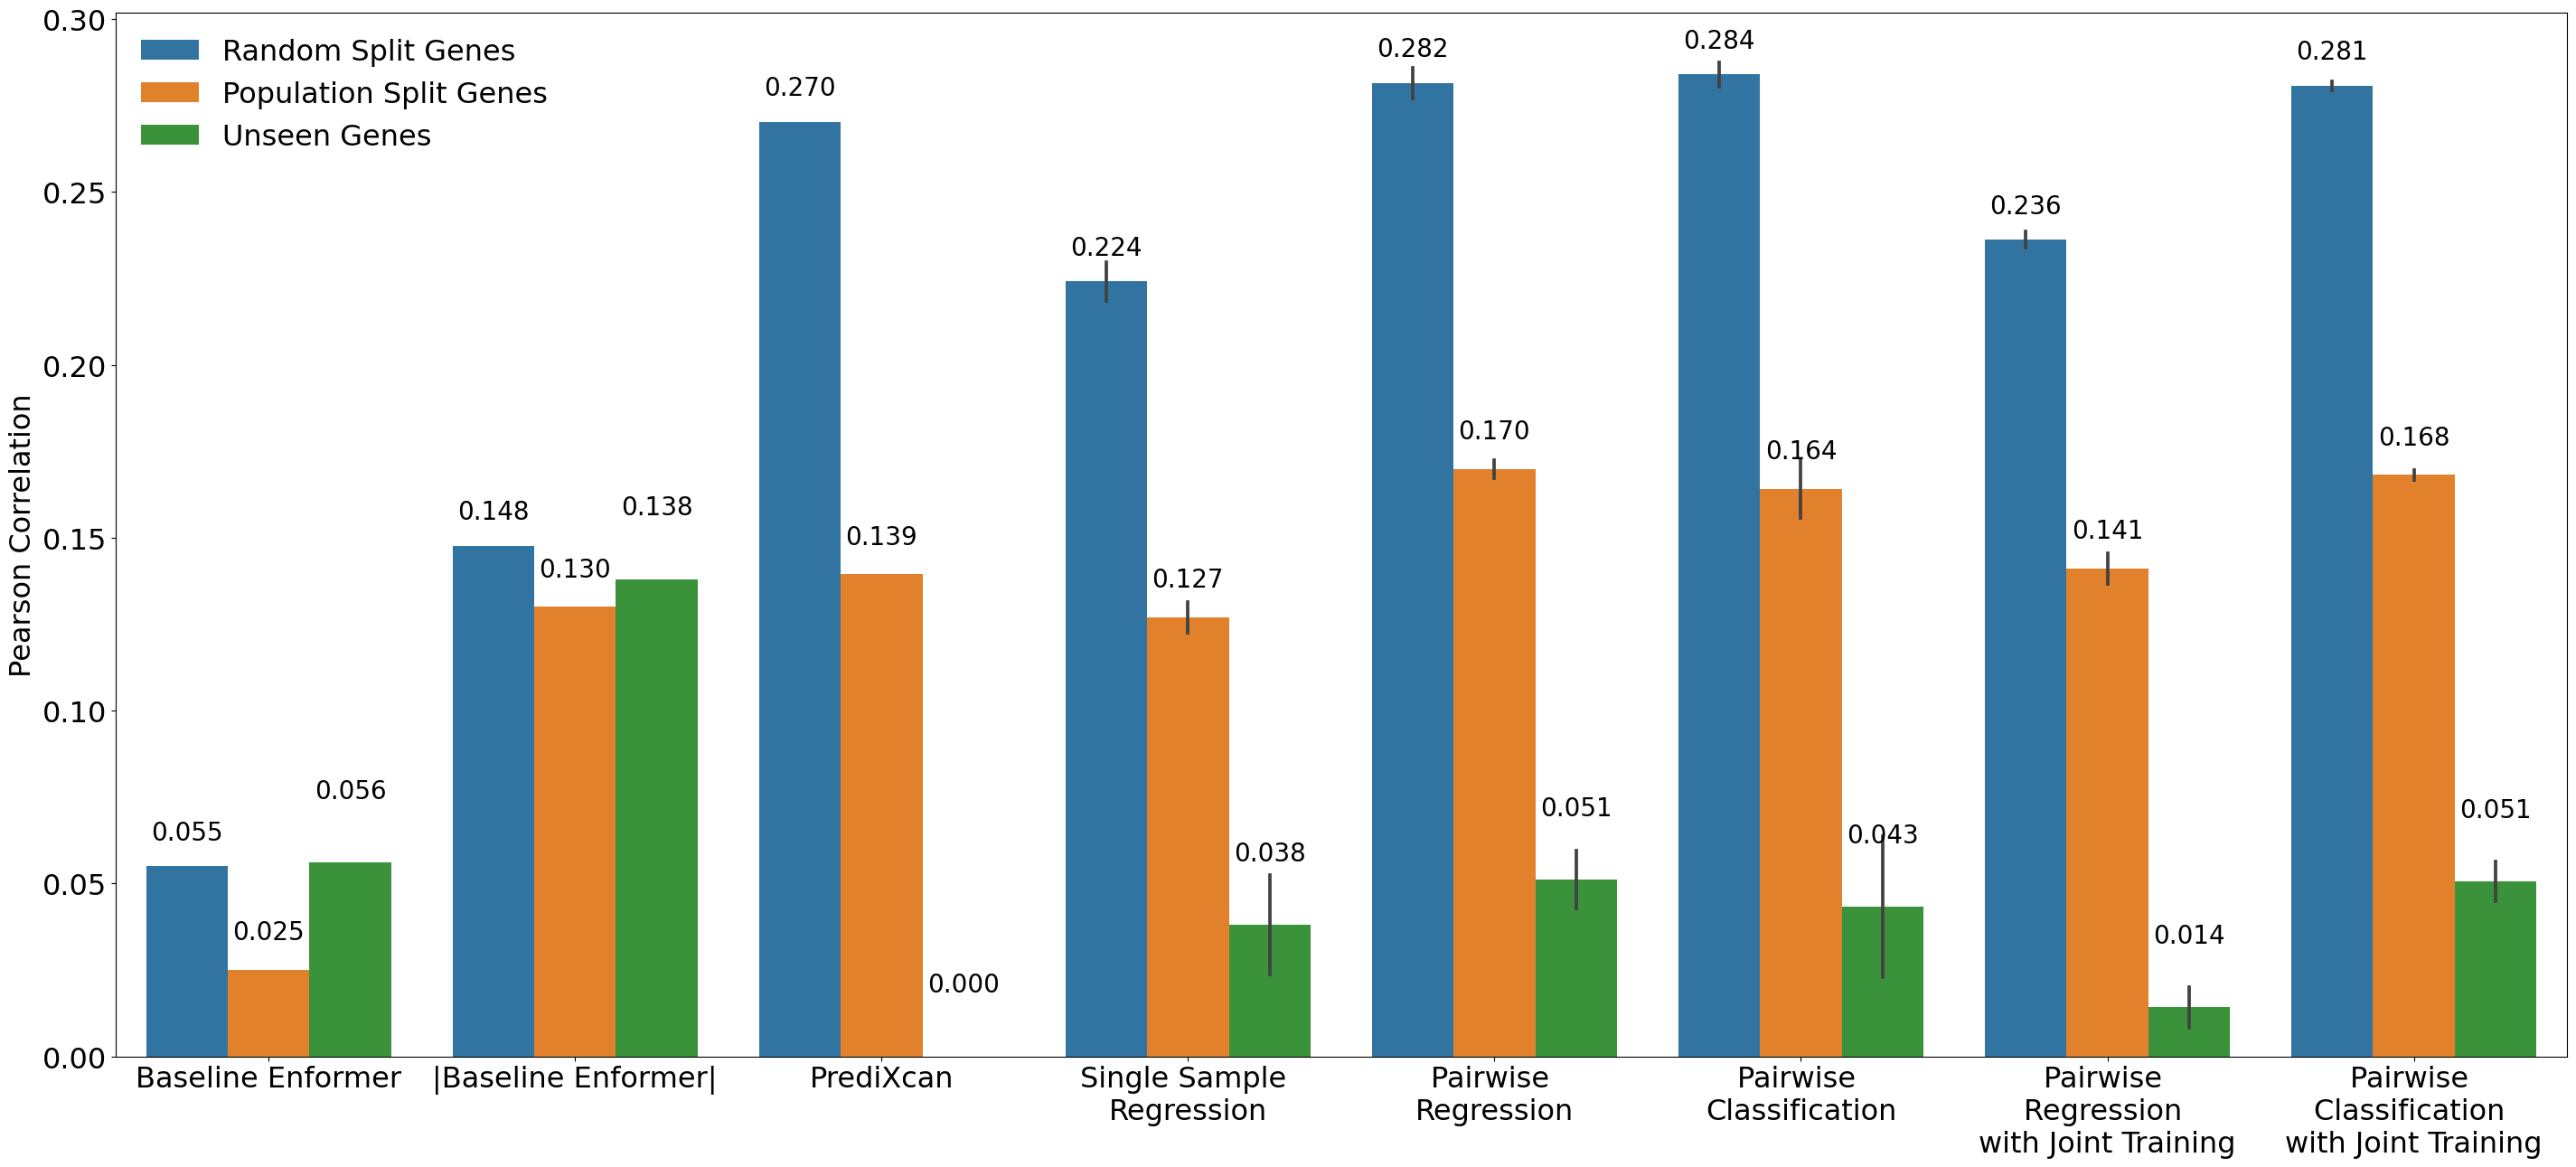

In [14]:
fontsize = 18
plt.rcParams.update({'font.size': fontsize+5})
matplotlib.rc('xtick', labelsize=fontsize+5) 
matplotlib.rc('ytick', labelsize=fontsize+5)
fig, ax = plt.subplots(figsize=(35, 15))

sns.barplot(data=plot_df, x="Model Type", y="Pearson Correlation", hue="Gene Classes", errorbar="sd", ax=ax,
           order=["Baseline Enformer", 
                  "|Baseline Enformer|", 
                  "PrediXcan", 
                  "Single Sample \nRegression", 
                  "Pairwise \nRegression", 
                  "Pairwise \nClassification", 
                  "Pairwise \nRegression \nwith Joint Training",
                  "Pairwise \nClassification \nwith Joint Training",])
ax.bar_label(ax.containers[0], fontsize=fontsize+2, padding=17, fmt="%.3f")
ax.bar_label(ax.containers[1], fontsize=fontsize+2, padding=20, fmt="%.3f")
ax.bar_label(ax.containers[2], fontsize=fontsize+2, padding=47, fmt="%.3f")
plt.xlabel("")
plt.legend(frameon=False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

os.makedirs("figures", exist_ok=True)
plt.savefig("figures/fig_1_comparison_of_all_methods.pdf")
# plt.tick_params(axis="x", labelrotation=45)

# Generate figure showing how performance scales with number of samples

In [15]:
plot_df = {}
plot_df["Subsample Ratio"] = []
plot_df["% of Samples Used for Training"] = []
plot_df["Replicate"] = []
plot_df["Gene Classes"] = []
plot_df["Pearson Correlation"] = []
# plot_df["Abs Pearson Correlation"] = []

for i in range(1, summary_df.shape[0]):
    row = summary_df.iloc[i]
    
    if row["Subsample Ratio"] == -1:
        continue        
    
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]*100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random Split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
#     plot_df["Abs Pearson Correlation"].append(row["random_split Genes Avg |PearsonR|"])
    
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]*100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population Split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
#     plot_df["Abs Pearson Correlation"].append(row["yri_split Genes Avg |PearsonR|"])
    
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]*100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
#     plot_df["Abs Pearson Correlation"].append(row["unseen Genes Avg |PearsonR|"])
    
plot_df = pd.DataFrame(plot_df)

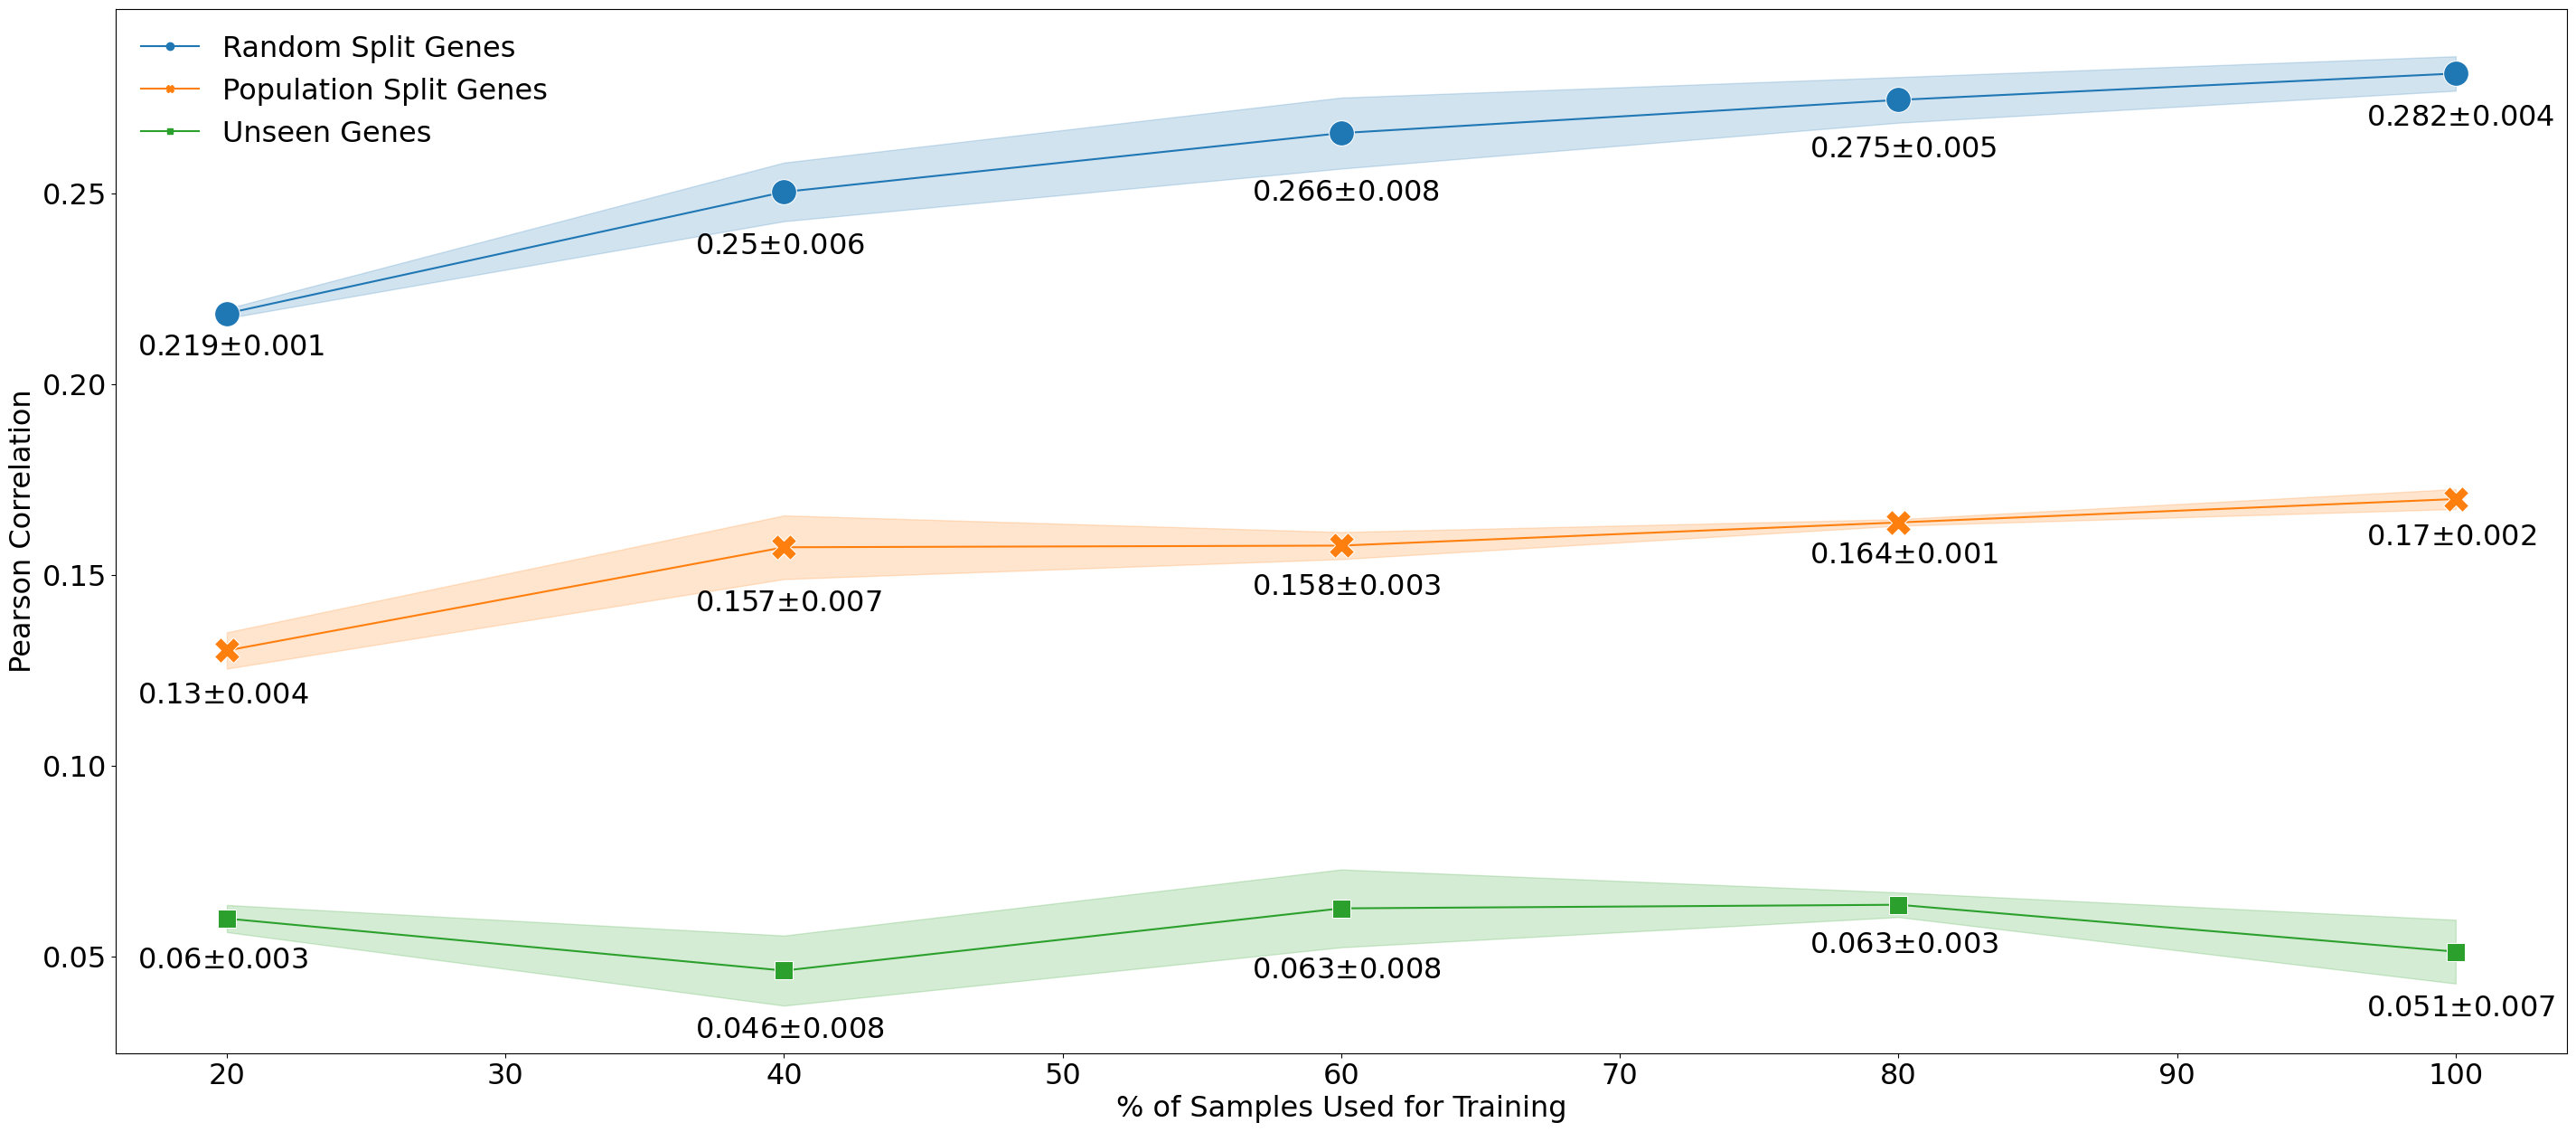

In [16]:
fontsize = 18
plt.rcParams.update({'font.size': fontsize+5})
matplotlib.rc('xtick', labelsize=fontsize+5) 
matplotlib.rc('ytick', labelsize=fontsize+5)
fig, ax = plt.subplots(figsize=(35, 15))

sns.lineplot(data=plot_df, 
             x="% of Samples Used for Training", 
             style="Gene Classes",
             y="Pearson Correlation", 
             hue="Gene Classes", 
             errorbar="sd", 
             ax=ax,
             markers=True, dashes=False, markersize=20,
#              err_style="bars",
             hue_order=["Random Split Genes", "Population Split Genes", "Unseen Genes"])

# label points on the plot
for x in set(plot_df["% of Samples Used for Training"]):
    for hue in set(plot_df["Gene Classes"]):
        corrs = plot_df[(plot_df["% of Samples Used for Training"] == x) & (plot_df["Gene Classes"] == hue)]["Pearson Correlation"]
        disp = f"{np.mean(corrs).round(3)}" + r"$\pm$" + f"{np.std(corrs).round(3)}"
    
        plt.text(x = x - 3.2, # x-coordinate position of data label
                 y = np.mean(corrs) - np.std(corrs) - 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
                 s = disp, # data label, formatted to ignore decimals
                 color = "black") # set colour of line

plt.legend(frameon=False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.savefig("figures/fig_1_perf_vs_num_samples.pdf")
# plt.tick_params(axis="x", labelrotation=45)